In [1]:
import os

# Check the uploaded files
os.listdir('/kaggle/input')

['pride-and-prejudice-jane-austen-txt']

In [3]:
import io

file_path = "/kaggle/input/pride-and-prejudice-jane-austen-txt/Pride_and_Prejudice-Jane_Austen.txt"

with io.open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

print(text[:1000])  # show first 1000 characters

The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org





Title: Pride and Prejudice


Author: Jane Austen

Editor: R. W. (Robert William) Chapman

Release Date: May 9, 2013  [eBook #42671]

Language: English


***START OF THE PROJECT GUTENBERG EBOOK PRIDE AND PREJUDICE***


E-text prepared by Greg Weeks, Jon Hurst, Mary Meehan, and the Online
Distributed Proofreading Team (http://www.pgdp.net) from page images
generously made available by Internet Archive (https://archive.org)



Note: Project Gutenberg also has an HTML version of this
      file which includes the original illustrations.
      See 42671-h.htm or 42671-h.zip:
      (http://www.gutenberg.org/files/42671/42671-h/42671-h.

In [12]:
# Convert to lowercase
t = text.lower()

# --- Identify start ---
# We search for "chapter i." since your file shows that
start_marker = "chapter i"
start_index = t.find(start_marker)

if start_index == -1:
    raise ValueError("Could not find the start of the novel. Check markers again.")

# --- Identify end ---
end_marker = "***END OF THE PROJECT GUTENBERG EBOOK PRIDE AND PREJUDICE***".lower()
end_index = t.find(end_marker)

if end_index == -1:
    raise ValueError("Could not find the end marker in the text.")

# Extract the cleaned novel text
clean_text = t[start_index:end_index].strip()

# Print start and end samples
print("START SAMPLE:\n", clean_text[:500])
print("\nEND SAMPLE:\n", clean_text[-500:])

START SAMPLE:
 chapter i.


it is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

however little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered as the rightful
property of some one or other of their daughters.

"my dear mr. bennet," said his lady to him one day, "have you heard that
netherfield park is let at last?"

END SAMPLE:
 

with the gardiners, they were always on the most intimate terms. darcy,
as well as elizabeth, really loved them; and they were both ever
sensible of the warmest gratitude towards the persons who, by bringing
her into derbyshire, had been the means of uniting them.




       *       *       *       *       *




transcriber's note:

spelling and hyphen changes have been made so that there is consistency
within the book. any other inconsistencies with modern spelli

In [13]:
import re

# Clean punctuation (keep .,!? for NLP structure)
clean_text2 = re.sub(r"[^a-zA-Z0-9\s\.\,\!\?\'\"]", " ", clean_text)

# Normalize spaces
clean_text2 = re.sub(r"\s+", " ", clean_text2).strip()

# Tokenize by splitting on space
tokens = clean_text2.split()

print("Total tokens:", len(tokens))
print("First 50 tokens:", tokens[:50])

Total tokens: 122799
First 50 tokens: ['chapter', 'i.', 'it', 'is', 'a', 'truth', 'universally', 'acknowledged,', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune,', 'must', 'be', 'in', 'want', 'of', 'a', 'wife.', 'however', 'little', 'known', 'the', 'feelings', 'or', 'views', 'of', 'such', 'a', 'man', 'may', 'be', 'on', 'his', 'first', 'entering', 'a', 'neighbourhood,', 'this', 'truth', 'is', 'so', 'well', 'fixed']


In [14]:
# Build vocabulary
vocab = sorted(set(tokens))
vocab_size = len(vocab)

# Mappings
stoi = {word: i for i, word in enumerate(vocab)}
itos = {i: word for i, word in enumerate(vocab)}

print("Vocabulary size:", vocab_size)

# Encode all tokens to integers
encoded = [stoi[word] for word in tokens]

print("Sample encoded sequence:", encoded[:20])

Vocabulary size: 11208
Sample encoded sequence: [1795, 5148, 5687, 5680, 292, 10272, 10461, 413, 9968, 292, 9200, 6278, 5293, 7724, 7036, 292, 4591, 4338, 6724, 1208]


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

SEQ_LEN = 30  # number of words per sequence

inputs = []
targets = []

for i in range(len(encoded) - SEQ_LEN):
    inp = encoded[i : i + SEQ_LEN]
    tgt = encoded[i + 1 : i + SEQ_LEN + 1]
    inputs.append(inp)
    targets.append(tgt)

print("Total sequences:", len(inputs))

Total sequences: 122769


In [16]:
class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create dataset
dataset = TextDataset(inputs, targets)

# Train/val split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

len(train_dataset), len(val_dataset)

(110492, 12277)

In [17]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)
        return logits, hidden

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMLanguageModel(vocab_size=vocab_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

model

LSTMLanguageModel(
  (embed): Embedding(11208, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=11208, bias=True)
)

In [19]:
def train_model(model, train_loader, val_loader, epochs=5, lr=0.002):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train = total_train_loss / len(train_loader)
        train_losses.append(avg_train)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                logits, _ = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                total_val_loss += loss.item()

        avg_val = total_val_loss / len(val_loader)
        val_losses.append(avg_val)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    return train_losses, val_losses

In [20]:
# UNDERFITTING MODEL
underfit_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=64,
    hidden_dim=64,
    num_layers=1,
    dropout=0.0
).to(device)

underfit_train_losses, underfit_val_losses = train_model(
    underfit_model,
    train_loader,
    val_loader,
    epochs=2,   # very few epochs
    lr=0.005    # slightly higher LR to exaggerate underfitting
)

Epoch 1/2 | Train Loss: 4.6868 | Val Loss: 3.7119
Epoch 2/2 | Train Loss: 3.2941 | Val Loss: 2.9801


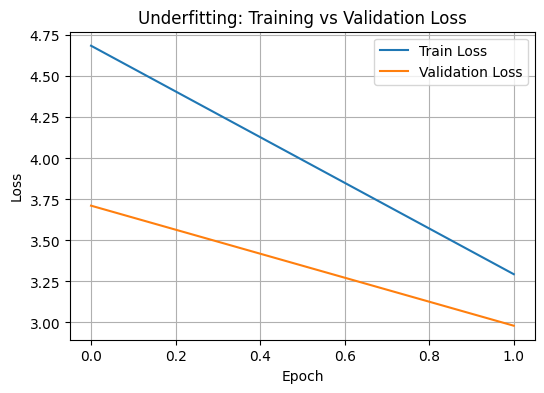

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(underfit_train_losses, label='Train Loss')
plt.plot(underfit_val_losses, label='Validation Loss')
plt.title("Underfitting: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# OVERFITTING MODEL - Large capacity, many epochs, low dropout
overfit_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=256,
    hidden_dim=512,
    num_layers=3,
    dropout=0.0
).to(device)

overfit_train_losses, overfit_val_losses = train_model(
    overfit_model,
    train_loader,
    val_loader,
    epochs=8,    # More epochs = likely to overfit
    lr=0.002
)

Epoch 1/8 | Train Loss: 5.9978 | Val Loss: 4.9635
Epoch 2/8 | Train Loss: 4.2036 | Val Loss: 3.4782
Epoch 3/8 | Train Loss: 2.8516 | Val Loss: 2.3418
Epoch 4/8 | Train Loss: 1.8811 | Val Loss: 1.6246
Epoch 5/8 | Train Loss: 1.2607 | Val Loss: 1.1527
Epoch 6/8 | Train Loss: 0.9030 | Val Loss: 0.9219
Epoch 7/8 | Train Loss: 0.7012 | Val Loss: 0.7636
Epoch 8/8 | Train Loss: 0.5863 | Val Loss: 0.7098


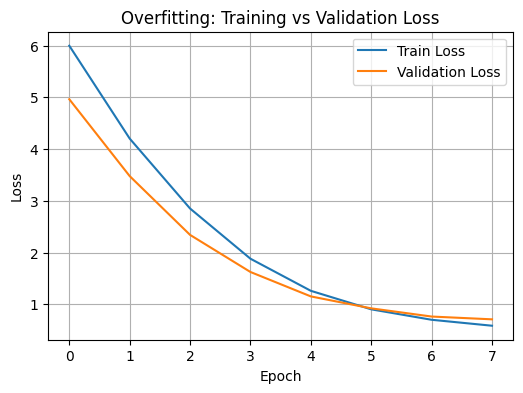

In [23]:
plt.figure(figsize=(6,4))
plt.plot(overfit_train_losses, label='Train Loss')
plt.plot(overfit_val_losses, label='Validation Loss')
plt.title("Overfitting: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# BEST-FIT MODEL 
best_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3
).to(device)

best_train_losses, best_val_losses = train_model(
    best_model,
    train_loader,
    val_loader,
    epochs=8,
    lr=0.002
)

Epoch 1/8 | Train Loss: 5.4837 | Val Loss: 4.2064
Epoch 2/8 | Train Loss: 3.5682 | Val Loss: 2.7589
Epoch 3/8 | Train Loss: 2.5549 | Val Loss: 1.9279
Epoch 4/8 | Train Loss: 1.9870 | Val Loss: 1.4536
Epoch 5/8 | Train Loss: 1.6380 | Val Loss: 1.1505
Epoch 6/8 | Train Loss: 1.4025 | Val Loss: 0.9512
Epoch 7/8 | Train Loss: 1.2345 | Val Loss: 0.8128
Epoch 8/8 | Train Loss: 1.1105 | Val Loss: 0.7195


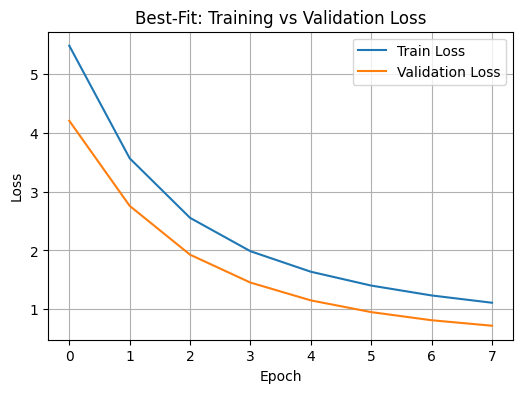

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.title("Best-Fit: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import math
final_val_loss = best_val_losses[-1]
perplexity = math.exp(final_val_loss)
print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Validation Perplexity: {perplexity:.4f}")

Final validation loss: 0.7195
Validation Perplexity: 2.0534


In [30]:
torch.save({
    'model_state_dict': best_model.state_dict(),
    'vocab': vocab,
    'stoi': stoi,
    'itos': itos,
    'seq_len': SEQ_LEN
}, "/kaggle/working/bestfit_8epoch_model.pth")

print("Saved as bestfit_8epoch_model.pth")

Saved as bestfit_8epoch_model.pth


In [31]:
# Underfit plot
plt.figure(figsize=(6,4))
plt.plot(underfit_train_losses, label='Train Loss')
plt.plot(underfit_val_losses, label='Validation Loss')
plt.title("Underfitting: Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.savefig("/kaggle/working/underfit_loss.png", bbox_inches='tight')
plt.close()

# Overfit plot
plt.figure(figsize=(6,4))
plt.plot(overfit_train_losses, label='Train Loss')
plt.plot(overfit_val_losses, label='Validation Loss')
plt.title("Overfitting: Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.savefig("/kaggle/working/overfit_loss.png", bbox_inches='tight')
plt.close()

# Best-fit plot
plt.figure(figsize=(6,4))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.title("Best-Fit: Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.savefig("/kaggle/working/bestfit_loss.png", bbox_inches='tight')
plt.close()

print("Saved underfit_loss.png, overfit_loss.png, bestfit_loss.png to /kaggle/working/")


Saved underfit_loss.png, overfit_loss.png, bestfit_loss.png to /kaggle/working/


In [32]:
import pandas as pd
df = pd.DataFrame({
    'underfit_train': underfit_train_losses + [None]*(max(len(underfit_train_losses), len(overfit_train_losses), len(best_train_losses)) - len(underfit_train_losses)),
    'underfit_val': underfit_val_losses + [None]*(max(len(underfit_train_losses), len(overfit_train_losses), len(best_train_losses)) - len(underfit_val_losses)),
    'overfit_train': overfit_train_losses + [None]*(max(len(underfit_train_losses), len(overfit_train_losses), len(best_train_losses)) - len(overfit_train_losses)),
    'overfit_val': overfit_val_losses + [None]*(max(len(underfit_train_losses), len(overfit_train_losses), len(best_train_losses)) - len(overfit_val_losses)),
    'best_train': best_train_losses + [None]*(max(len(underfit_train_losses), len(overfit_train_losses), len(best_train_losses)) - len(best_train_losses)),
    'best_val': best_val_losses + [None]*(max(len(underfit_train_losses), len(overfit_train_losses), len(best_train_losses)) - len(best_val_losses)),
})
csv_path = "/kaggle/working/losses_summary.csv"
df.to_csv(csv_path, index=False)
print("Saved losses CSV to:", csv_path)

Saved losses CSV to: /kaggle/working/losses_summary.csv


In [35]:
# ---------- Text Generation Function ----------
def generate_text(model, stoi, itos, start_text="elizabeth", max_len=100, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device

    # Fallback token = index of space " "
    fallback = stoi.get(" ", 0)

    # Convert start text to tokens (no <unk> in vocab)
    tokens = [stoi.get(c, fallback) for c in start_text.lower()]
    input_seq = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    hidden = None
    generated = start_text

    for _ in range(max_len):
        logits, hidden = model(input_seq, hidden)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1).item()
        generated += itos[next_token]

        input_seq = torch.tensor([[next_token]], dtype=torch.long).to(device)

    return generated


# ---------- LOAD BEST-FIT CHECKPOINT ----------
checkpoint = torch.load("/kaggle/working/bestfit_8epoch_model.pth", map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])
print("Model loaded successfully.")

# ---------- GENERATE TEXT ----------
output = generate_text(
    best_model,
    stoi=checkpoint['stoi'],
    itos=checkpoint['itos'],
    start_text=" elizabeth",
    max_len=300,
    temperature=0.5
)

print("\n--- Generated Text ---\n")
print(output)

Model loaded successfully.

--- Generated Text ---

 elizabethisallmypretensionstopleaseawomanworthyofbeingpleased.""hadyouthenpersuadedyourselfthatishould?""indeedihad.whatwillyouthinkitatlast.icouldhavenocharmsforme.ishouldinfinitelypreferabook."butofitwouldbewisdomtoresist?allthaticanpromiseyou,therefore,isnottobeinahurry.iwillnotbesurprised,"saiddarcy,"ifheweretogiveitup,assoonasanyeligiblepurchaseoffers."elizabethmadenoanswer.shewasafraidoftalkinglongerofmr.bingley'sfirstchoice.""yesbutheseemedtolikehissecondbetter.""oh!youmeanjane,isupposebecausehedancedwithhertwice.tobesurethatdidnotcomeback,hadtheyfixedonhertohint,waslikelytobehardenedinallherfollyandassurance,byasituationofsuchdoubledangerasawateringplaceandacamp.uponthewhole,therefore,shefound,whathasbeensometimesfoundbefore,thataneventtowhichshehadyesterdaywitnessed,howevertemporaryitsexistencemightprove,hadatleastoutlivedoneday.whenshesawhimthusseekingtheacquaintance,andcourtingthegoodopinionofpeople,withwhomanyintercourseh